In [154]:
import numpy as np

In [155]:
def getDis(X1, X2): #算兩點間的歐式距離
    sum = 0
    for i in range(0,2):
        sum += (X1[i] - X2[i])**2
    return round(math.sqrt(sum),2)

def csvToList(filename):
    with open(filename,'r') as f:
        # allLine : CSV的每row變成一string的string list 
        # readlines後面的[1:]表示從第一行之後開始讀，也可以用next(f)達到這個目的
        allLines = f.readlines()[1:]  
        f.closed
        dataList = [] 
        for line in allLines: # line : CSV各row變成的string
            # line.split(',')將各line以','為單位分割，x.strip()是刪去分割後各element的前後空白符和換行符號
            item = [x.strip() for x in line.split(',')] 
            item = list(map(int, item))
            # 在dataList這個二維list中加入item這個list
            dataList.append(item) 
    return dataList   

def loadLists(nodeNum, dataList):
    nodes = []
    triT = {}
    oriT = {}
    staT = {}
    coor = {}
    coor[-1] = [0, 0]
    coor[0] = [0, 0]
    for i in range(0,nodeNum):
        nodes.append(dataList[i][0])
        coor[dataList[i][0]] = [dataList[i][1], dataList[i][2]]
        staT[dataList[i][0]] = dataList[i][3]
        triT[dataList[i][0],-1] = getDis(coor[dataList[i][0]], [0,0])
        triT[-1,dataList[i][0]] = getDis(coor[dataList[i][0]], [0,0])
    for i in range(0,nodeNum):
        for j in range(0,nodeNum):
            triT[dataList[i][0],dataList[j][0]] = getDis(coor[dataList[i][0]], coor[dataList[j][0]])
    return nodes, coor, triT, staT, oriT



In [156]:
def crossSet(allnodes, coor):
    cross = []
    for i in allnodes:
        for j in allnodes:
            for k in allnodes:
                for l in allnodes:
                    if(judgeRectangleCoincide(coor[i], coor[j], coor[k], coor[l])):
                        cross.append([i,j,k,l])
    return cross

def judgeRectangleCoincide(a, b, c, d):
    if min(a[0],b[0])<max(c[0],d[0]) and min(c[1],d[1])<max(a[1],b[1]) and min(c[0],d[0])<max(a[0],b[0]) \
    and min(a[1],b[1])<max(c[1],d[1]):
        return judgeCross(a, b, c, d)
    else:
        return False
    
def judgeCross(a, b, c, d):
    u = (c[0]-a[0])*(b[1]-a[1]) - (b[0]-a[0])*(c[1]-a[1])
    v = (d[0]-a[0])*(b[1]-a[1]) - (b[0]-a[0])*(d[1]-a[1])
    w = (a[0]-c[0])*(d[1]-c[1]) - (d[0]-c[0])*(a[1]-c[1])
    z = (b[0]-c[0])*(d[1]-c[1]) - (d[0]-c[0])*(b[1]-c[1])
    return u*v<0 and w*z<0

In [157]:
from gurobipy import *
m = Model("m")
nodeList = csvToList('10node.csv')
nodeNum = len(nodeList) # nodeNum = 10
armNum = 3

levels = [n for n in range(1,nodeNum+1)] # level 1~10 
# 虛擬level: + [0] 虛擬起訖點(-1)
arms = [n for n in range(0,armNum)] # arm 0

nodes, coor, triT, staT, oriT = loadLists(nodeNum, nodeList)


dummynode = [-1]
allnodes = nodes + dummynode # node 1~10 + end node -1
cross = crossSet(allnodes, coor)

x = {}
y = {}
Z = {}

# add variables
for k in arms:
    x[0,k,-1] = m.addVar(vtype=GRB.BINARY, name = 'x_l%s_k%s_i%s'%(0,k,-1))
    for l in levels:
        for i in allnodes:
            x[l,k,i] = m.addVar(vtype=GRB.BINARY, name = 'x_l%s_k%s_i%s'%(l,k,i))
    for l in [0]+levels:
        for i in allnodes:
            for j in allnodes:
                if i==j: continue
                y[l,k,i,j] = m.addVar(vtype=GRB.BINARY, name = 'y_l%s_k%s_i%s_j%s'%(l,k,i,j))
    

Z = m.addVar(vtype=GRB.INTEGER, name = 'Z')

m.update()

In [158]:
# each point can be welded once among all arms
for i in nodes: 
    m.addConstr(quicksum(x[l,k,i] for l in levels for k in arms) == 1, 'point_lim_%s'%(i))

# dummy point should be starting and ending point once for each arm
for k in arms:
    m.addConstr(x[0,k,-1] == 1, 'start_from_-1_k%s'%(k))
    #m.addConstr(quicksum(x[0,k,i] for i in allnodes) == 1, 'level_0_of_k%s'%(k))
    m.addConstr(quicksum(y[l,k,-1,i] for l in levels+[0] for i in nodes) == 1, 'starting_%s'%(k))
    m.addConstr(quicksum(y[l,k,i,-1] for l in levels+[0] for i in nodes) == 1, 'ending__%s'%(k))
    
# each level can weld one point for each arm
for l in levels:
    for k in arms:
        m.addConstr(quicksum(x[l,k,i] for i in allnodes) == 1, 'lev_lim_l%s_k%s'%(l,k))
        
# relation between x and y
for k in arms:
    m.addConstr(quicksum(y[0,k,-1,j] for j in nodes if i!=j) == x[0,k,-1], 'setXout_l%s_k%s_i%s'%(0,k,-1))

for l in levels:
    for i in nodes:
        for k in arms:
            m.addConstr(quicksum(y[l,k,i,j] for j in allnodes if i!=j) == x[l,k,i], 'setXout_l%s_k%s_i%s'%(l,k,i))

for l in levels:
    for i in nodes:
        for k in arms:
            m.addConstr(quicksum(y[l-1,k,j,i] for j in allnodes if i!=j) == x[l,k,i], 'setXin_l%s_k%s_i%s'%(l,k,i))
        
# no cross
# for pair in cross:
#     m.addConstr(quicksum(y[l,k,pair[0],pair[1]] + y[l,k,pair[1],pair[0]] + \
#                 y[l,k,pair[2],pair[3]] + y[l,k,pair[3],pair[2]] for l in levels+[0] for k in arms) <= 1, \
#                 'noCross_(%s,%s)_(%s,%s)'%(pair[0],pair[1],pair[2],pair[3]))
# for pair in cross:
#     m.addConstr(quicksum(y[l,k,pair[0],pair[1]] + y[l,k,pair[2],pair[3]] for l in levels+[0] for k in arms) <= 1, \
#                 'noCross_(%s,%s)_(%s,%s)'%(pair[0],pair[1],pair[2],pair[3]))
    
# set Z
for k in arms:
     m.addConstr(quicksum(staT[i]*x[l,k,i] for l in levels for i in nodes) + \
               quicksum(triT[i,j]*y[l,k,i,j] for l in levels+[0] for i in allnodes for j in allnodes if i!=j)  \
                <= Z, 'setZ')
        
m.setObjective(Z, GRB.MINIMIZE)
m.optimize()


Gurobi Optimizer version 9.0.1 build v9.0.1rc0 (win64)
Optimize a model with 655 rows, 3964 columns and 11856 nonzeros
Model fingerprint: 0x6c657b4c
Variable types: 0 continuous, 3964 integer (3963 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 60 rows and 912 columns
Presolve time: 0.06s
Presolved: 595 rows, 3052 columns, 9501 nonzeros
Variable types: 0 continuous, 3052 integer (3051 binary)
Found heuristic solution: objective 358.0000000

Root relaxation: objective 9.294065e+01, 967 iterations, 0.04 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   92.94065    0  111  358.00000   92.94065  74.0%     -    0s
H    0     0                     197.0000000   92.94065  52.8%     -    0s
     0     0   96.20777    0   88  197.00000 

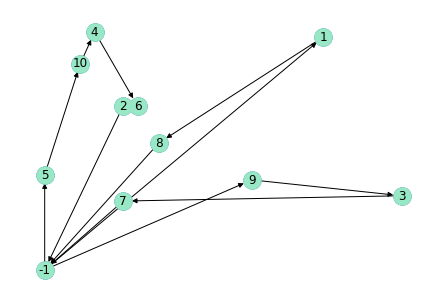

In [159]:
import networkx as nx
# s=0
if m.status == GRB.Status.OPTIMAL:
    G = nx.DiGraph()
    for l in levels+[0]:
        for k in arms:
            for i in allnodes:
                G.add_node(i, pos=(coor[i][0],coor[i][1]))
                for j in allnodes:
                    if i==j: continue
                    if y[l,k,i,j].x > 0:
#                         print (k, ' ', i, '->', j, ':', triT[i,j])
#                         s+=triT[i,j]
                        G.add_edge(i, j)

# print(s)
nx.draw(G, nx.get_node_attributes(G, 'pos'), with_labels=True)  
nx.draw_networkx_nodes(G, nx.get_node_attributes(G, 'pos'), G.nodes(), node_color="#98e8c5")

In [160]:
print("opt. value =", m.ObjVal)
for v in m.getVars():
    if v.X>0:
        print(v.VarName, v.X)

opt. value = 128.0
x_l0_k0_i-1 1.0
x_l1_k0_i9 1.0
x_l2_k0_i3 1.0
x_l3_k0_i7 1.0
x_l4_k0_i-1 1.0
x_l5_k0_i-1 1.0
x_l6_k0_i-1 1.0
x_l7_k0_i-1 1.0
x_l8_k0_i-1 1.0
x_l9_k0_i-1 1.0
x_l10_k0_i-1 1.0
y_l0_k0_i-1_j9 1.0
y_l1_k0_i9_j3 1.0
y_l2_k0_i3_j7 1.0
y_l3_k0_i7_j-1 1.0
x_l0_k1_i-1 1.0
x_l1_k1_i5 1.0
x_l2_k1_i10 1.0
x_l3_k1_i4 1.0
x_l4_k1_i6 1.0
x_l5_k1_i2 1.0
x_l6_k1_i-1 1.0
x_l7_k1_i-1 1.0
x_l8_k1_i-1 1.0
x_l9_k1_i-1 1.0
x_l10_k1_i-1 1.0
y_l0_k1_i-1_j5 1.0
y_l1_k1_i5_j10 1.0
y_l2_k1_i10_j4 1.0
y_l3_k1_i4_j6 1.0
y_l4_k1_i6_j2 1.0
y_l5_k1_i2_j-1 1.0
x_l0_k2_i-1 1.0
x_l1_k2_i1 1.0
x_l2_k2_i8 1.0
x_l3_k2_i-1 1.0
x_l4_k2_i-1 1.0
x_l5_k2_i-1 1.0
x_l6_k2_i-1 1.0
x_l7_k2_i-1 1.0
x_l8_k2_i-1 1.0
x_l9_k2_i-1 1.0
x_l10_k2_i-1 1.0
y_l0_k2_i-1_j1 1.0
y_l1_k2_i1_j8 1.0
y_l2_k2_i8_j-1 1.0
Z 128.0


In [161]:
cross

[[1, 2, 3, 4],
 [1, 2, 3, 10],
 [1, 2, 4, 3],
 [1, 2, 4, 6],
 [1, 2, 4, 8],
 [1, 2, 4, 9],
 [1, 2, 6, 4],
 [1, 2, 6, 10],
 [1, 2, 8, 4],
 [1, 2, 9, 4],
 [1, 2, 9, 10],
 [1, 2, 10, 3],
 [1, 2, 10, 6],
 [1, 2, 10, 9],
 [1, 5, 2, 3],
 [1, 5, 2, 7],
 [1, 5, 2, 8],
 [1, 5, 2, 9],
 [1, 5, 2, -1],
 [1, 5, 3, 2],
 [1, 5, 3, 4],
 [1, 5, 3, 6],
 [1, 5, 3, 10],
 [1, 5, 4, 3],
 [1, 5, 4, 7],
 [1, 5, 4, 8],
 [1, 5, 4, 9],
 [1, 5, 4, -1],
 [1, 5, 6, 3],
 [1, 5, 6, 7],
 [1, 5, 6, 8],
 [1, 5, 6, 9],
 [1, 5, 6, -1],
 [1, 5, 7, 2],
 [1, 5, 7, 4],
 [1, 5, 7, 6],
 [1, 5, 7, 10],
 [1, 5, 8, 2],
 [1, 5, 8, 4],
 [1, 5, 8, 6],
 [1, 5, 8, 10],
 [1, 5, 9, 2],
 [1, 5, 9, 4],
 [1, 5, 9, 6],
 [1, 5, 9, 10],
 [1, 5, 10, 3],
 [1, 5, 10, 7],
 [1, 5, 10, 8],
 [1, 5, 10, 9],
 [1, 5, 10, -1],
 [1, 5, -1, 2],
 [1, 5, -1, 4],
 [1, 5, -1, 6],
 [1, 5, -1, 10],
 [1, 6, 3, 4],
 [1, 6, 3, 10],
 [1, 6, 4, 3],
 [1, 6, 4, 9],
 [1, 6, 9, 4],
 [1, 6, 9, 10],
 [1, 6, 10, 3],
 [1, 6, 10, 9],
 [1, 7, 2, 3],
 [1, 7, 2, 9],
 [1, 7, 3, 2